In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.insert(0, '../')

from global_config import config
from utils.plot_utils import *

from statsmodels.nonparametric.smoothers_lowess import lowess

data_dir = config.get_property('covid_fb2')

dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

In [67]:
data_cases_path = os.path.join(data_dir, 'agglomerated', 'geometry')
cases_df        = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])

dict_correct    = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

cases_df["poly_id"]   = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))
cases_df["poly_name"] = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"] = cases_df["poly_name"].replace( dict_correct )
cases_df              = cases_df.rename(columns={'poly_id': 'locality_id', 'poly_name': 'locality'})
cases_bog_df          = cases_df.groupby(['locality_id', 'location', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df          = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})
cases_bog_df = cases_bog_df.rename(columns={'confirm': 'cases'})
cases_bog_df

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/2445276796.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  cases_bog_df          = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/2445276796.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  cases_bog_df          = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'conf

,date,location,locality_id,cases,deaths,icu
0,2020-02-26,20 DE JULIO,san_cristobal,0.0,0.0,0.0
1,2020-02-26,AEROPUERTO EL DORADO,fontibon,0.0,0.0,0.0
2,2020-02-26,ALAMOS,engativa,0.0,0.0,0.0
3,2020-02-26,ALFONSO LOPEZ,usme,0.0,0.0,0.0
4,2020-02-26,AMERICAS,kennedy,0.0,0.0,0.0
...,...,...,...,...,...,...
54629,2021-06-02,USAQUEN,usaquen,0.0,0.0,0.0
54630,2021-06-02,VENECIA,tunjuelito,0.0,0.0,0.0
54631,2021-06-02,VERBENAL,usaquen,0.0,0.0,0.0
54632,2021-06-02,ZONA FRANCA,fontibon,0.0,0.0,0.0


In [68]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                        'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                        'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

def correct_locality(loc):
    if loc in list(dict_correct.keys()):
        return dict_correct[loc]
    return loc

localities = [" ".join( [l.capitalize() for l in loc.split("_")]) for loc in cases_bog_df.locality_id.unique()]
localities = [correct_locality(l) for l in localities]


In [69]:
bog_df = cases_bog_df.groupby(['date']).sum().reset_index()[["date", "cases", "deaths", "icu"]]
bog_df = bog_df[bog_df["date"] <= pd.to_datetime("2020-09-20")]
#bog_df = bog_df[bog_df["date"] >= pd.to_datetime("2020-06-15")]

# --- # --- # --- #

bog_w_df                  = bog_df.set_index('date').resample('W-Sun').sum().reset_index()
bog_w_df["weekly_cases"]  = bog_w_df["cases"]  / 7
bog_w_df["weekly_deaths"] = bog_w_df["deaths"] / 7

bog_w_df                 = bog_w_df.iloc[:]



In [70]:
dates_prelockdown = pd.date_range(start = pd.to_datetime("12-07-2020", dayfirst=True) - pd.Timedelta(days=30),
                                  end  = pd.to_datetime("12-07-2020", dayfirst=True), freq='D')

# Del 13 al 26 de julio
dates_lockdown01 = pd.date_range(start = pd.to_datetime("13-07-2020", dayfirst=True),
                                end    = pd.to_datetime("26-07-2020", dayfirst=True), freq='D')
# Del 23 de julio al 6 de agosto
dates_lockdown02 = pd.date_range(start = pd.to_datetime("23-07-2020", dayfirst=True),
                                end    = pd.to_datetime("06-08-2020", dayfirst=True), freq='D')
# Del 31 de julio y al 14 de agosto
dates_lockdown03 = pd.date_range(start = pd.to_datetime("31-07-2020", dayfirst=True),
                                end    = pd.to_datetime("14-08-2020", dayfirst=True), freq='D')
# Del 16 al 30 de agosto
dates_lockdown04 = pd.date_range(start = pd.to_datetime("16-08-2020", dayfirst=True),
                                end    = pd.to_datetime("30-08-2020", dayfirst=True), freq='D')

# 'San Cristóbal', 'Fontibón', 'Engativá', 'Usme', 'Kennedy', 'Bosa', 'Ciudad Bolívar', 'Suba',
#     'Chapinero', 'Antonio Narino', 'Puente Aranda', 'Teusaquillo', 'Usaquén',
#     'Rafael Uribe Uribe', 'Barrios Unidos', 'La Candelaria', 'Santa Fe', 'Los Mártires', 'Tunjuelito'

# Ciudad Bolívar, San Cristóbal, Rafael Uribe Uribe, Chapinero, Santa Fe, Usme, Los Mártires y Tunjuelito
locs_01 = ["Ciudad Bolívar", "San Cristóbal", "Rafael Uribe Uribe", "Chapinero",
                                "Santa Fe", "Usme", "Los Mártires", "Tunjuelito"]
# Bosa, Antonio Nariño, Kennedy, Puente Aranda y Fontibón
locs_02 = ["Bosa", "Antonio Nariño", "Kennedy", "Puente Aranda", "Fontibón"]
# Suba, Engativá y Barrios Unidos.
locs_03 = ["Suba", "Engativá", "Barrios Unidos"]
# Usaquén, Chapinero, Santa Fe, La Candelaria, Teusaquillo, Puente Aranda y Antonio Nariño.
locs_04 = ["Usaquén", "Chapinero", "Santa Fe", "La Candelaria",
                    "Teusaquillo", "Puente Aranda", "Antonio Nariño"]


In [71]:
dates_big_lockdown01 = [pd.to_datetime("20-03-2020", dayfirst=True), pd.to_datetime("26-04-2020", dayfirst=True)]
dates_big_lockdown02 = [pd.to_datetime("27-04-2020", dayfirst=True), pd.to_datetime("25-05-2020", dayfirst=True)]


In [72]:
from datetime import timedelta
import geopandas as gpd
from shapely import wkt
import geopandas as gpd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import os, sys

sys.path.insert(0, '../')

from global_config import config

geo_dir             = config.get_property('geo_dir')
path_to_bog_polygon = os.path.join(geo_dir, 'localities', 'localities_shapefile.shp')

# Read bogota polygons divided by localities.
polygons_bog = gpd.read_file( path_to_bog_polygon )
polygons_bog = polygons_bog.rename(columns={'location_i': 'location_id'})


In [73]:
# Read bogota polygons divided by localities.
polygons_bog = gpd.read_file( path_to_bog_polygon )
polygons_bog = polygons_bog.rename(columns={'location_i': 'location_id'})

g1           = ['Chapinero', 'Los Mártires', 'San Cristóbal', 'Tunjuelito',
              'Rafael Uribe Uribe', 'Ciudad Bolívar', 'Santa Fe', 'Usme']
g2           = ['Bosa', 'Antonio Nariño', 'Kennedy', 'Puente Aranda', 'Fontibón']
g3           = ['Suba', 'Engativá', 'Barrios Unidos']
g4           = ['Usaquén', 'Chapinero', 'Santa Fe', 'La Candelaria', 'Teusaquillo', 'Puente Aranda', 'Antonio Nariño']
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}
polygons_bog['label'] = polygons_bog['label'].replace(dict_correct)
# --- # --- # --- #
polygons_bog["group_1"]       = None
polygons_bog["group_1_label"] = None
polygons_bog["group_2"]       = None
polygons_bog["group_2_label"] = None
polygons_bog["group_3"]       = None
polygons_bog["group_3_label"] = None
polygons_bog["group_4"]       = None
polygons_bog["group_4_label"] = None
# --- # --- # --- #

for loc in g1:
    polygons_bog["group_1"][polygons_bog.label==loc]       = True
    polygons_bog["group_1_label"][polygons_bog.label==loc] = loc

for loc in g2:
    polygons_bog["group_2"][polygons_bog.label==loc]=True
    polygons_bog["group_2_label"][polygons_bog.label==loc]=loc

for loc in g3:
    polygons_bog["group_3"][polygons_bog.label==loc]=True
    polygons_bog["group_3_label"][polygons_bog.label==loc]=loc

for loc in g4:
    polygons_bog["group_4"][polygons_bog.label==loc]=True
    polygons_bog["group_4_label"][polygons_bog.label==loc]=loc

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/1525911436.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  polygons_bog["group_1"][polygons_bog.label==loc]       = True
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/i

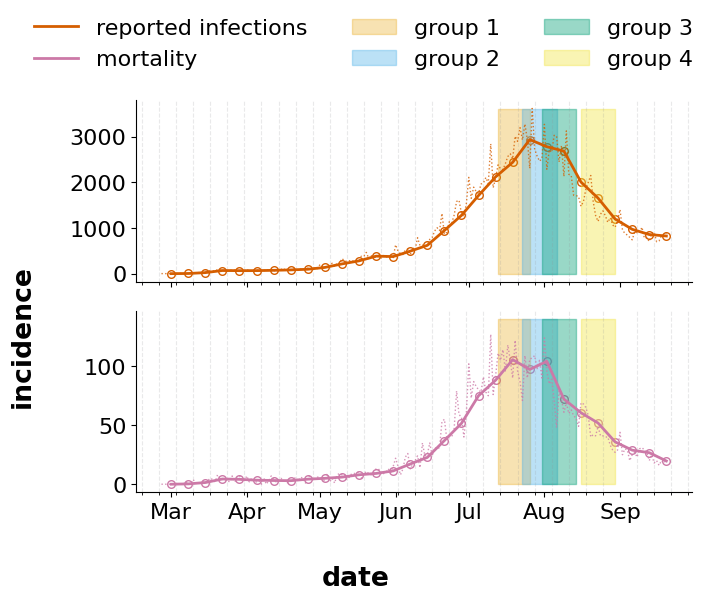

In [74]:
palette_guide = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
palette_grays = ["#231D1F", "#939597"]

fig, ax = plt.subplots(2, 1, figsize=(7.2, 5.2), sharex=True)

ax[0].plot(bog_df["date"], bog_df["cases"], color=palette_guide[-2], ls=":", lw=1, alpha=0.8)
l_inf,  = ax[0].plot(bog_w_df["date"], bog_w_df["weekly_cases"], lw=2, ls="-", color=palette_guide[-2], label="reported infections")
ax[0].scatter(bog_w_df["date"], bog_w_df["weekly_cases"], ec=palette_guide[-2], fc="w", s=30)


lg1 = ax[0].fill_between([dates_lockdown01[0], dates_lockdown01[-1]], 0, 3600, color = palette_guide[0], alpha=0.3, label = "group 1")
lg2 = ax[0].fill_between([dates_lockdown02[0], dates_lockdown02[-1]], 0, 3600, color = palette_guide[1], alpha=0.4, label = "group 2")
lg3 = ax[0].fill_between([dates_lockdown03[0], dates_lockdown03[-1]], 0, 3600, color = palette_guide[2], alpha=0.4, label = "group 3")
lg4 = ax[0].fill_between([dates_lockdown04[0], dates_lockdown04[-1]], 0, 3600, color = palette_guide[3], alpha=0.4, label = "group 4")

ax[1].plot(bog_df["date"], bog_df["deaths"], color=palette_guide[-1], ls=":", lw=1, alpha=0.8)
l_deaths, = ax[1].plot(bog_w_df["date"], bog_w_df["weekly_deaths"], lw=2, ls="-", color=palette_guide[-1], label="mortality")
ax[1].scatter(bog_w_df["date"], bog_w_df["weekly_deaths"], ec=palette_guide[-1], fc="w", s=30)
ax[1].fill_between([dates_lockdown01[0], dates_lockdown01[-1]], 0, 140, color = palette_guide[0], alpha=0.3)
ax[1].fill_between([dates_lockdown02[0], dates_lockdown02[-1]], 0, 140, color = palette_guide[1], alpha=0.4)
ax[1].fill_between([dates_lockdown03[0], dates_lockdown03[-1]], 0, 140, color = palette_guide[2], alpha=0.4)
ax[1].fill_between([dates_lockdown04[0], dates_lockdown04[-1]], 0, 140, color = palette_guide[3], alpha=0.4)

fig.legend(handles=[l_inf, l_deaths, lg1, lg2, lg3, lg4], ncols=3,
                    loc='upper left', bbox_to_anchor=(0.025, 1.15), frameon=False)

fig.supylabel("incidence", weight='bold')
fig.supxlabel("date", weight='bold')

for axi in ax.flatten():
    axi.grid(axis='x', which="minor", linestyle='--', alpha=0.2, color=palette_grays[1])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axi.tick_params(which='both', axis='x', labelrotation=0)
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

plt.tight_layout()


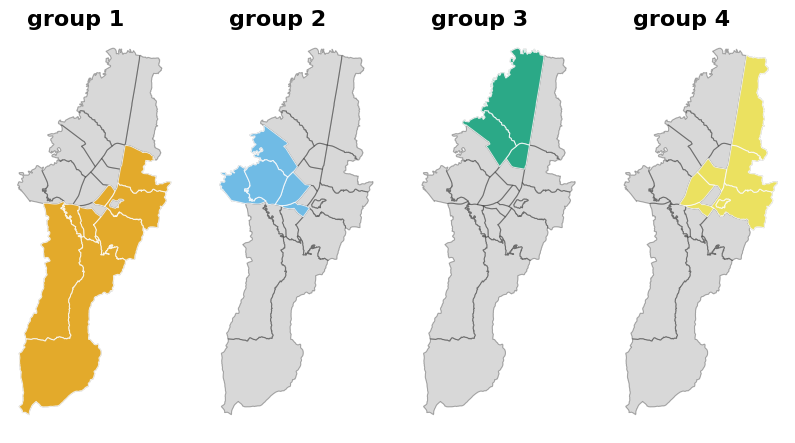

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(10, 7.2), sharex=True, sharey=True)

groups = ["group_1", "group_2", "group_3", "group_4"]
for i_axi, axi in enumerate(ax.flatten()):

    maps1 = polygons_bog.plot(ax=axi, edgecolor='k', alpha=0.3, facecolor='Grey', linewidth=0.8)
    maps2 = polygons_bog[polygons_bog[groups[i_axi]]==True].plot(ax=axi, edgecolor="w",
                                    facecolor = palette_guide[i_axi], alpha=0.8, linewidth=0.8)
    axi.text(x=0.1, y=1.01, weight="bold", s=f"group {i_axi+1}", transform=axi.transAxes)
    axi.set_axis_off()
    axi.transAxes


In [76]:
cases_bog_df["locality"] = cases_bog_df["locality_id"].apply(lambda loc: correct_locality(" ".join( [l.capitalize() for l in loc.split("_")])))

localities_left = list(set(cases_bog_df.locality.unique()) - set(locs_01))

cases_gr01_df            = cases_bog_df[cases_bog_df["locality"].isin(locs_01)]
cases_not_gr01_df        = cases_bog_df[cases_bog_df["locality"].isin(localities_left)]

bog_g01_df     = cases_gr01_df.groupby(['date']).sum().reset_index()[["date", "cases", "deaths", "icu"]]
bog_g01_df     = bog_g01_df[bog_g01_df["date"].isin(dates_lockdown01)]

bog_not_g01_df = cases_not_gr01_df.groupby(['date']).sum().reset_index()[["date", "cases", "deaths", "icu"]]
bog_not_g01_df = bog_not_g01_df[bog_not_g01_df["date"].isin(dates_lockdown01)]

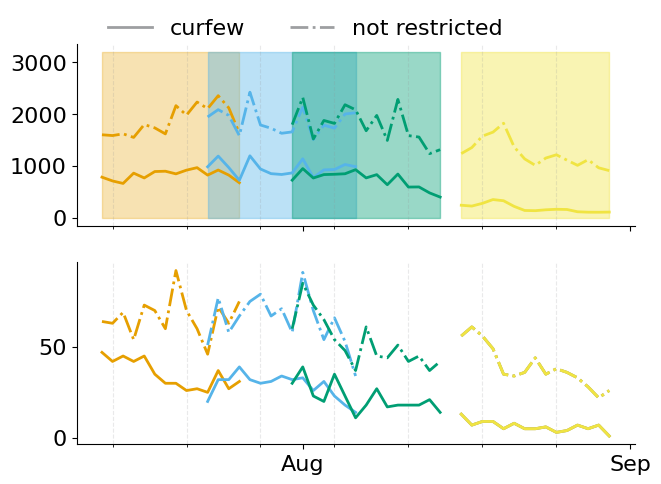

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(7.2, 5.2), sharex=True)

dates_lockdown = [dates_lockdown01, dates_lockdown02, dates_lockdown03, dates_lockdown04]
for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):


    localities_left = list(set(cases_bog_df.locality.unique()) - set(lockdown))

    cases_gr01_df     = cases_bog_df[cases_bog_df["locality"].isin(lockdown)]
    cases_not_gr01_df = cases_bog_df[cases_bog_df["locality"].isin(localities_left)]

    #
    bog_g01_df     = cases_gr01_df.groupby(['date']).sum().reset_index()[["date", "cases", "deaths", "icu"]]
    bog_g01_df     = bog_g01_df[bog_g01_df["date"].isin(dates_lockdown[i_lck])]
    ax[0].plot(bog_g01_df["date"], bog_g01_df["cases"],         color=palette_guide[i_lck], ls="-", lw=2, alpha=1)
    ax[1].plot(bog_g01_df["date"], bog_g01_df["deaths"],         color=palette_guide[i_lck], ls="-", lw=2, alpha=1)
    #

    bog_not_g01_df = cases_not_gr01_df.groupby(['date']).sum().reset_index()[["date", "cases", "deaths", "icu"]]
    bog_not_g01_df = bog_not_g01_df[bog_not_g01_df["date"].isin(dates_lockdown[i_lck])]

    ax[0].plot(bog_not_g01_df["date"], bog_not_g01_df["cases"], color=palette_guide[i_lck], ls="-.", lw=2, alpha=1)
    ax[1].plot(bog_not_g01_df["date"], bog_not_g01_df["deaths"], color=palette_guide[i_lck], ls="-.", lw=2, alpha=1)

lg1 = ax[0].fill_between([dates_lockdown01[0], dates_lockdown01[-1]], 0, 3200, color = palette_guide[0], alpha=0.3, label = "group 1")
lg2 = ax[0].fill_between([dates_lockdown02[0], dates_lockdown02[-1]], 0, 3200, color = palette_guide[1], alpha=0.4, label = "group 2")
lg3 = ax[0].fill_between([dates_lockdown03[0], dates_lockdown03[-1]], 0, 3200, color = palette_guide[2], alpha=0.4, label = "group 3")
lg4 = ax[0].fill_between([dates_lockdown04[0], dates_lockdown04[-1]], 0, 3200, color = palette_guide[3], alpha=0.4, label = "group 4")

for axi in ax.flatten():
    axi.grid(axis='x', which="minor", linestyle='--', alpha=0.2, color=palette_grays[1])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axi.tick_params(which='both', axis='x', labelrotation=0)
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.spines['right'].set_visible( False )
    axi.spines['top'].set_visible( False )


ax[1].plot(bog_g01_df["date"], bog_g01_df["deaths"],         color=palette_grays[1], ls="-",  lw=2, alpha=0.9, label="curfew")
ax[1].plot(bog_not_g01_df["date"], bog_not_g01_df["deaths"], color=palette_grays[1], ls="-.", lw=2, alpha=0.9, label="not restricted")

ax[1].legend(loc='upper left', bbox_to_anchor=(0.02, 2.45), frameon=False, ncol=2)

ax[1].plot(bog_g01_df["date"], bog_g01_df["deaths"],         color=palette_guide[i_lck], ls="-", lw=2,  alpha=1)
ax[1].plot(bog_not_g01_df["date"], bog_not_g01_df["deaths"], color=palette_guide[i_lck], ls="-.", lw=2, alpha=1)


In [78]:
from global_config import config

results_dir = config.get_property('results2_dir')

movement_df                  = pd.read_csv(os.path.join(results_dir, 'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
movement_df["start_poly_id"] = movement_df.start_poly_id.apply(lambda s: ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
movement_df["end_poly_id"]   = movement_df.end_poly_id.apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
movement_df                  = movement_df.replace( dict_correct )
movement_df

int_mov_df        = movement_df[movement_df.start_poly_id==movement_df.end_poly_id]
ext_mov_df        = movement_df[movement_df.start_poly_id!=movement_df.end_poly_id]


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/640092185.py:160: UserWarning: You passed a edgecolor/edgecolors ('#E69F00') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/640092185.py:160: UserWarning: You passed a edgecolor/edgecolors ('#56B4E9') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/640092185.py:160: UserWarning: You passed a edgecolor/edgecolors ('#009E73') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future

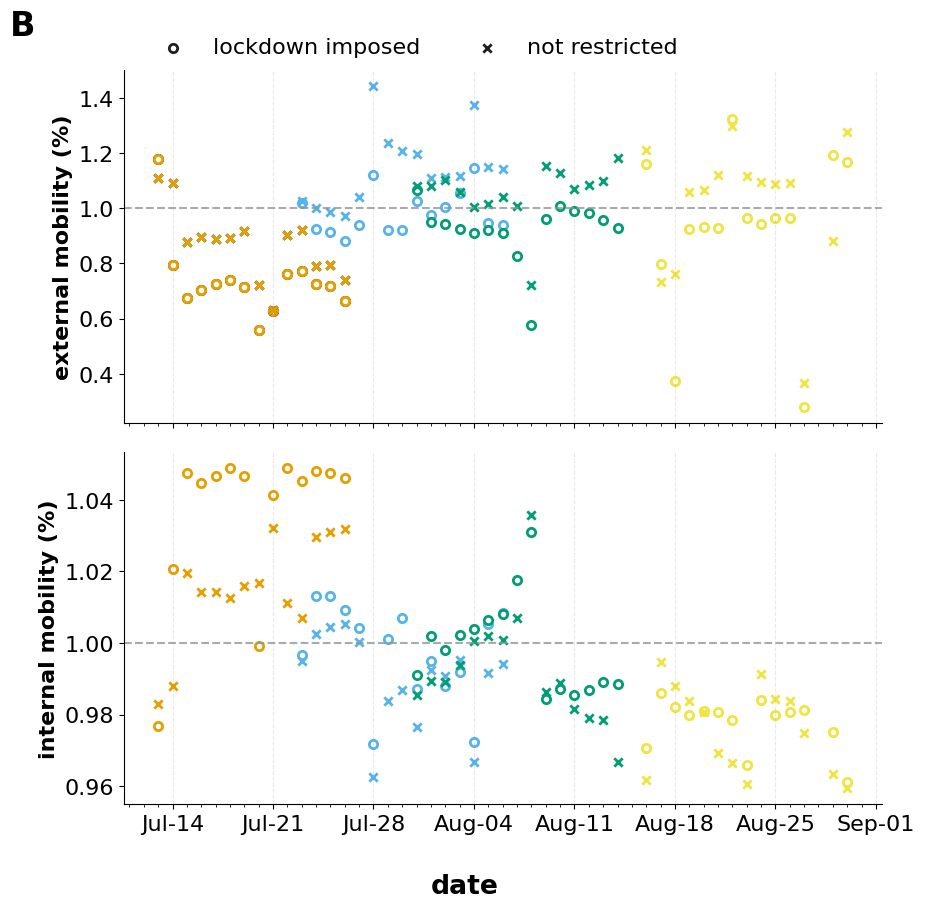

In [79]:
external_mov_df = []

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.2), sharex=True, sharey=False)

for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):
    localities_left = list(set(cases_bog_df.locality.unique()) - set(lockdown))
    if i_lck > 0:
        prev_dates = dates_lockdown[i_lck-1]
    else:
        prev_dates =  dates_lockdown[i_lck] - pd.Timedelta(days=14) #dates_lockdown[i_lck-1]


    ext_mov_gr01_df     = ext_mov_df[ext_mov_df["start_poly_id"].isin(lockdown)]
    ext_mov_not_gr01_df = ext_mov_df[ext_mov_df["start_poly_id"].isin(localities_left)]

    # - #
    ext_g01_df                = ext_mov_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_g01_df                = ext_g01_df[ext_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    ext_g01_df["day_of_week"] = ext_g01_df["date_time"].apply(lambda x: x.weekday())
    # - #

    ext_prev_g01_df                = ext_mov_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_prev_g01_df                = ext_prev_g01_df[ext_prev_g01_df["date_time"].isin(prev_dates)]
    ext_prev_g01_df["day_of_week"] = ext_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    ext_prev_g01_df                = ext_prev_g01_df.groupby(['start_poly_id', 'end_poly_id', 'day_of_week']).mean().reset_index()

    ext_g01_df                           = pd.merge(ext_g01_df, ext_prev_g01_df[["start_poly_id", "end_poly_id", "day_of_week", "movement"]], on=["start_poly_id", "end_poly_id", "day_of_week"], how="outer")
    ext_g01_df["change_in_ext_movement"] = ext_g01_df["movement_x"] / ext_g01_df["movement_y"]

    ext_g01_mean_df = ext_g01_df[["date_time", "change_in_ext_movement"]].groupby(['date_time']).mean().reset_index()
    external_mov_df = external_mov_df + [ext_g01_mean_df]

    ext_g01_df['pair']     = ext_g01_df.apply(lambda x: x.start_poly_id+"-"+x.end_poly_id, axis=1)
    mean_ext_df            = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.mean()
    quantiles_df           = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").quantile([0.05, 0.95], axis=1).T
    quantiles_df["mean"]   = mean_ext_df
    quantiles_df["median"] = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.median()
    quantiles_df = quantiles_df.dropna()

    external_mov_df = external_mov_df + [quantiles_df]

    label = None
    if i_lck == 0:
        label = "lockdown imposed"
        ax[0].scatter(quantiles_df.index.values, quantiles_df["median"], label=label,
                                                    ec=palette_grays[0], fc="w", lw=2, alpha=1)

    ax[0].scatter(quantiles_df.index.values, quantiles_df["median"],
                                                    ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)

    #for i in range(len(quantiles_df)):
    #    q_i_df = quantiles_df.iloc[i]
    #    plt.plot([q_i_df.name, q_i_df.name], [[q_i_df[0.05]], [q_i_df[0.95]]], c=palette_guide[i_lck], lw=2, alpha=0.5)

    # - # - # HERE FOR THE LOCALITIES NOT QUARANTINED # - # - #

    ext_g01_df                = ext_mov_not_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_g01_df                = ext_g01_df[ext_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    ext_g01_df["day_of_week"] = ext_g01_df["date_time"].apply(lambda x: x.weekday())

    ext_prev_g01_df                = ext_mov_not_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_prev_g01_df                = ext_prev_g01_df[ext_prev_g01_df["date_time"].isin(prev_dates)]
    ext_prev_g01_df["day_of_week"] = ext_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    ext_prev_g01_df                = ext_prev_g01_df.groupby(['start_poly_id', 'end_poly_id', 'day_of_week']).mean().reset_index()

    ext_g01_df                           = pd.merge(ext_g01_df, ext_prev_g01_df[["start_poly_id", "end_poly_id", "day_of_week", "movement"]], on=["start_poly_id", "end_poly_id", "day_of_week"], how="outer")
    ext_g01_df["change_in_ext_movement"] = ext_g01_df["movement_x"] / ext_g01_df["movement_y"]

    ext_g01_mean_df = ext_g01_df[["date_time", "change_in_ext_movement"]].groupby(['date_time']).mean().reset_index()
    external_mov_df = external_mov_df + [ext_g01_mean_df]

    ext_g01_df['pair']     = ext_g01_df.apply(lambda x: x.start_poly_id+"-"+x.end_poly_id, axis=1)
    mean_ext_df            = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.mean()
    quantiles_df           = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").quantile([0.05, 0.95], axis=1).T
    quantiles_df["mean"]   = mean_ext_df
    quantiles_df["median"] = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.median()
    quantiles_df = quantiles_df.dropna()

    external_mov_df = external_mov_df + [quantiles_df]

    label = None
    if i_lck == 0:
        label = "not restricted"
        ax[0].scatter(quantiles_df.index.values, quantiles_df["median"], c=palette_grays[0], lw=2, marker="x", label=label)

    ax[0].scatter(quantiles_df.index.values, quantiles_df["median"], c=palette_guide[i_lck], lw=2, marker="x")
    #for i in range(len(quantiles_df)):
    #    q_i_df = quantiles_df.iloc[i]
    #    #plt.plot([q_i_df.name, q_i_df.name], [[q_i_df[0.05]], [q_i_df[0.95]]], c=palette_guide[i_lck], lw=2, ls="--", alpha=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.15), frameon=False, ncol=2)
ax[0].axhline(y=1, color=palette_grays[1], ls="--", lw=1.5, alpha=0.8)
ax[0].set_ylabel("external mobility (%)", weight="bold")

external_mov_df = pd.concat(external_mov_df)


############## - ############## - ##############

for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):
    localities_left     = list(set(cases_bog_df.locality.unique()) - set(lockdown))
    int_mov_gr01_df     = int_mov_df[int_mov_df["start_poly_id"].isin(lockdown)]
    int_mov_not_gr01_df = int_mov_df[int_mov_df["start_poly_id"].isin(localities_left)]

    bog_g01_df          = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df          = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]

    if i_lck > 0:
        pre_dates_lock = dates_lockdown[i_lck-1]
    else:
        pre_dates_lock = dates_lockdown[i_lck] - pd.Timedelta(days=14)

    bog_prev_g01_df = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_prev_g01_df = bog_prev_g01_df[bog_prev_g01_df["date_time"].isin(pre_dates_lock)]
    ##
    bog_prev_g01_df["day_of_week"] = bog_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_prev_g01_df                = bog_prev_g01_df.groupby(['day_of_week']).mean().reset_index()
    bog_g01_df["day_of_week"]      = bog_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_g01_df                     = pd.merge(bog_g01_df, bog_prev_g01_df[["day_of_week", "movement"]],
                                                                            on="day_of_week", how="outer")
    bog_g01_df["change_in_internal_movement"] = bog_g01_df["movement_x"] / bog_g01_df["movement_y"]
    bog_g01_df["group"] = i_lck+1

    if i_lck == 3:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.6, it=10)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        ax[1].scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)
    elif i_lck==0:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.55, it=100)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        ax[1].scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)
    else:

        ax[1].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"], ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)

    ####  not locked down

    bog_prev_g01_df = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_prev_g01_df = bog_prev_g01_df[bog_prev_g01_df["date_time"].isin(pre_dates_lock)]
    ##
    bog_prev_g01_df["day_of_week"] = bog_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_prev_g01_df                = bog_prev_g01_df.groupby(['day_of_week']).mean().reset_index()

    bog_g01_df                     = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df                     = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    bog_g01_df["day_of_week"]      = bog_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_g01_df                     = pd.merge(bog_g01_df, bog_prev_g01_df[["day_of_week", "movement"]],
                                                                            on="day_of_week", how="outer")
    bog_g01_df["change_in_internal_movement"] = bog_g01_df["movement_x"] / bog_g01_df["movement_y"]
    bog_g01_df["group"] = i_lck+1

    if i_lck == 3:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.6, it=10)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        ax[1].scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), marker="x", fc=palette_guide[i_lck], lw=2, alpha=1, label="not restricted")
    else:
        ax[1].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
                                            ec=palette_guide[i_lck], marker="x", fc=palette_guide[i_lck], lw=2, alpha=1)
    #intern_mov_df = intern_mov_df + [bog_g01_df]

ax[1].axhline(y=1, color=palette_grays[1], ls="--", lw=1.5, alpha=0.8)
ax[1].set_ylabel("internal mobility (%)", weight="bold")

for axi in ax:
    axi.grid(axis='x', which="major", linestyle='--', alpha=0.2, color=palette_grays[1])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axi.tick_params(which='both', axis='x', labelrotation=0)
    axi.xaxis.set_major_locator(mdates.WeekdayLocator())
    axi.xaxis.set_minor_locator(mdates.DayLocator())
    axi.spines['right'].set_visible( False )
    axi.spines['top'].set_visible( False )

ax[0].text(x=-0.15, y=1.1, s="B", weight="bold", transform=ax[0].transAxes, fontsize=24)

fig.supxlabel("date", weight='bold')

plt.tight_layout()
fig.savefig(os.path.join('figures',  'Fig1_mobility_changes.png'), dpi=300, bbox_inches='tight')

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/221839428.py:68: UserWarning: You passed a edgecolor/edgecolors ('#E69F00') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/221839428.py:68: UserWarning: You passed a edgecolor/edgecolors ('#56B4E9') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/221839428.py:68: UserWarning: You passed a edgecolor/edgecolors ('#009E73') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.sc

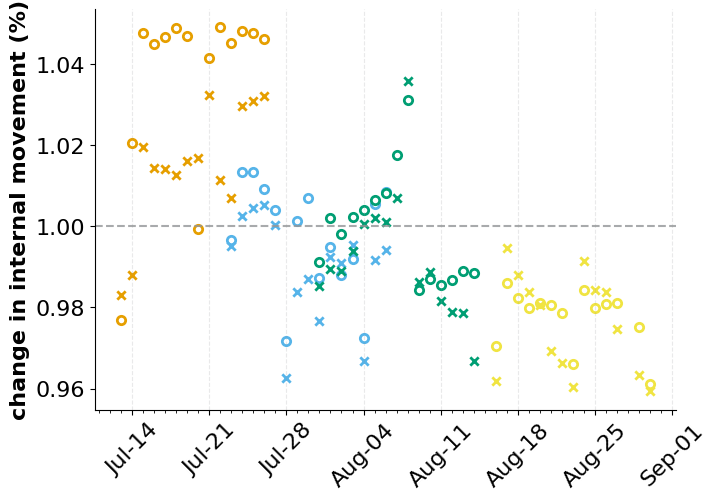

In [80]:
intern_mov_df = []

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.2), sharex=True)


for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):
    localities_left     = list(set(cases_bog_df.locality.unique()) - set(lockdown))
    int_mov_gr01_df     = int_mov_df[int_mov_df["start_poly_id"].isin(lockdown)]
    int_mov_not_gr01_df = int_mov_df[int_mov_df["start_poly_id"].isin(localities_left)]

    bog_g01_df          = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df          = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]

    if i_lck > 0:
        pre_dates_lock = dates_lockdown[i_lck-1]
    else:
        pre_dates_lock = dates_lockdown[i_lck] - pd.Timedelta(days=14)

    bog_prev_g01_df = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_prev_g01_df = bog_prev_g01_df[bog_prev_g01_df["date_time"].isin(pre_dates_lock)]
    ##
    bog_prev_g01_df["day_of_week"] = bog_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_prev_g01_df                = bog_prev_g01_df.groupby(['day_of_week']).mean().reset_index()
    bog_g01_df["day_of_week"]      = bog_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_g01_df                     = pd.merge(bog_g01_df, bog_prev_g01_df[["day_of_week", "movement"]],
                                                                            on="day_of_week", how="outer")
    bog_g01_df["change_in_internal_movement"] = bog_g01_df["movement_x"] / bog_g01_df["movement_y"]
    bog_g01_df["group"] = i_lck+1

    if i_lck == 3:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.6, it=10)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        ax.scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)
    elif i_lck==0:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.55, it=100)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        ax.scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)
    else:

        ax.scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"], ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)

    ####  not locked down

    bog_prev_g01_df = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_prev_g01_df = bog_prev_g01_df[bog_prev_g01_df["date_time"].isin(pre_dates_lock)]
    ##
    bog_prev_g01_df["day_of_week"] = bog_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_prev_g01_df                = bog_prev_g01_df.groupby(['day_of_week']).mean().reset_index()



    bog_g01_df                     = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df                     = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    bog_g01_df["day_of_week"]      = bog_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_g01_df                     = pd.merge(bog_g01_df, bog_prev_g01_df[["day_of_week", "movement"]],
                                                                            on="day_of_week", how="outer")
    bog_g01_df["change_in_internal_movement"] = bog_g01_df["movement_x"] / bog_g01_df["movement_y"]
    bog_g01_df["group"] = i_lck+1

    if i_lck == 3:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.6, it=10)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        ax.scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), marker="x", fc=palette_guide[i_lck], lw=2, alpha=1, label="not restricted")
    else:
        ax.scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
                                            ec=palette_guide[i_lck], marker="x", fc=palette_guide[i_lck], lw=2, alpha=1)


    intern_mov_df = intern_mov_df + [bog_g01_df]

ax.axhline(y=1, color=palette_grays[1], ls="--", lw=1.5, alpha=0.8)
ax.set_ylabel("change in internal movement (%)", weight="bold")

intern_mov_df = pd.concat(intern_mov_df)

for axi in [ax]:
    axi.grid(axis='x', which="major", linestyle='--', alpha=0.2, color=palette_grays[1])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axi.tick_params(which='both', axis='x', labelrotation=45)
    axi.xaxis.set_major_locator(mdates.WeekdayLocator()) #MonthLocator())
    axi.xaxis.set_minor_locator(mdates.DayLocator())
    axi.spines['right'].set_visible( False )
    axi.spines['top'].set_visible( False )

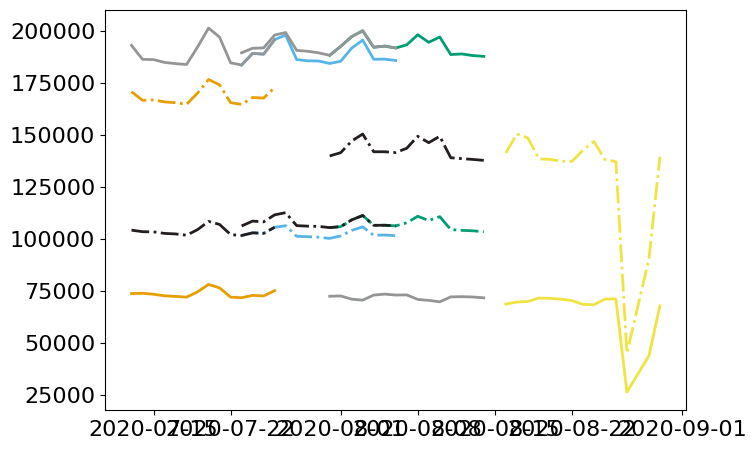

In [81]:

movement_df                  = pd.read_csv(os.path.join(results_dir, 'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
movement_df["start_poly_id"] = movement_df.start_poly_id.apply(lambda s: ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
movement_df["end_poly_id"]   = movement_df.end_poly_id.apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
movement_df                  = movement_df.replace( dict_correct )
movement_df

int_mov_df        = movement_df[movement_df.start_poly_id==movement_df.end_poly_id]
ext_mov_df        = movement_df[movement_df.start_poly_id==movement_df.end_poly_id]

i_lck, lockdown = 0, locs_01

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.2), sharex=True)

for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):

    localities_left = list(set(cases_bog_df.locality.unique()) - set(lockdown))

    int_mov_gr01_df     = int_mov_df[int_mov_df["start_poly_id"].isin(lockdown)]
    int_mov_not_gr01_df = int_mov_df[int_mov_df["start_poly_id"].isin(localities_left)]

    bog_g01_df     = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df     = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    ax.plot(bog_g01_df["date_time"], bog_g01_df["movement"], color=palette_guide[i_lck], ls="-", lw=2, alpha=1)

    if i_lck > 0:
        bog_g01_df     = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
        bog_g01_df     = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck-1])]
        ax.plot(bog_g01_df["date_time"], bog_g01_df["movement"],         color=palette_grays[1], ls="-", lw=2, alpha=1)

    bog_not_g01_df = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_not_g01_df = bog_not_g01_df[bog_not_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    ax.plot(bog_not_g01_df["date_time"], bog_not_g01_df["movement"], color=palette_guide[i_lck], ls="-.", lw=2, alpha=1)

    if i_lck > 0:
        bog_not_g01_df     = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
        bog_not_g01_df     = bog_not_g01_df[bog_not_g01_df["date_time"].isin(dates_lockdown[i_lck-1])]
        ax.plot(bog_not_g01_df["date_time"], bog_not_g01_df["movement"], color=palette_grays[0], ls="-.", lw=2, alpha=1)



In [84]:
int_mov_df        = movement_df[movement_df.start_poly_id==movement_df.end_poly_id]
ext_mov_df        = movement_df[movement_df.start_poly_id!=movement_df.end_poly_id]


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/3935880725.py:171: UserWarning: You passed a edgecolor/edgecolors ('#E69F00') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes["internal"].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/3935880725.py:171: UserWarning: You passed a edgecolor/edgecolors ('#56B4E9') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes["internal"].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_17706/3935880725.py:171: UserWarning: You passed a edgecolor/edgecolors ('#009E73') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior

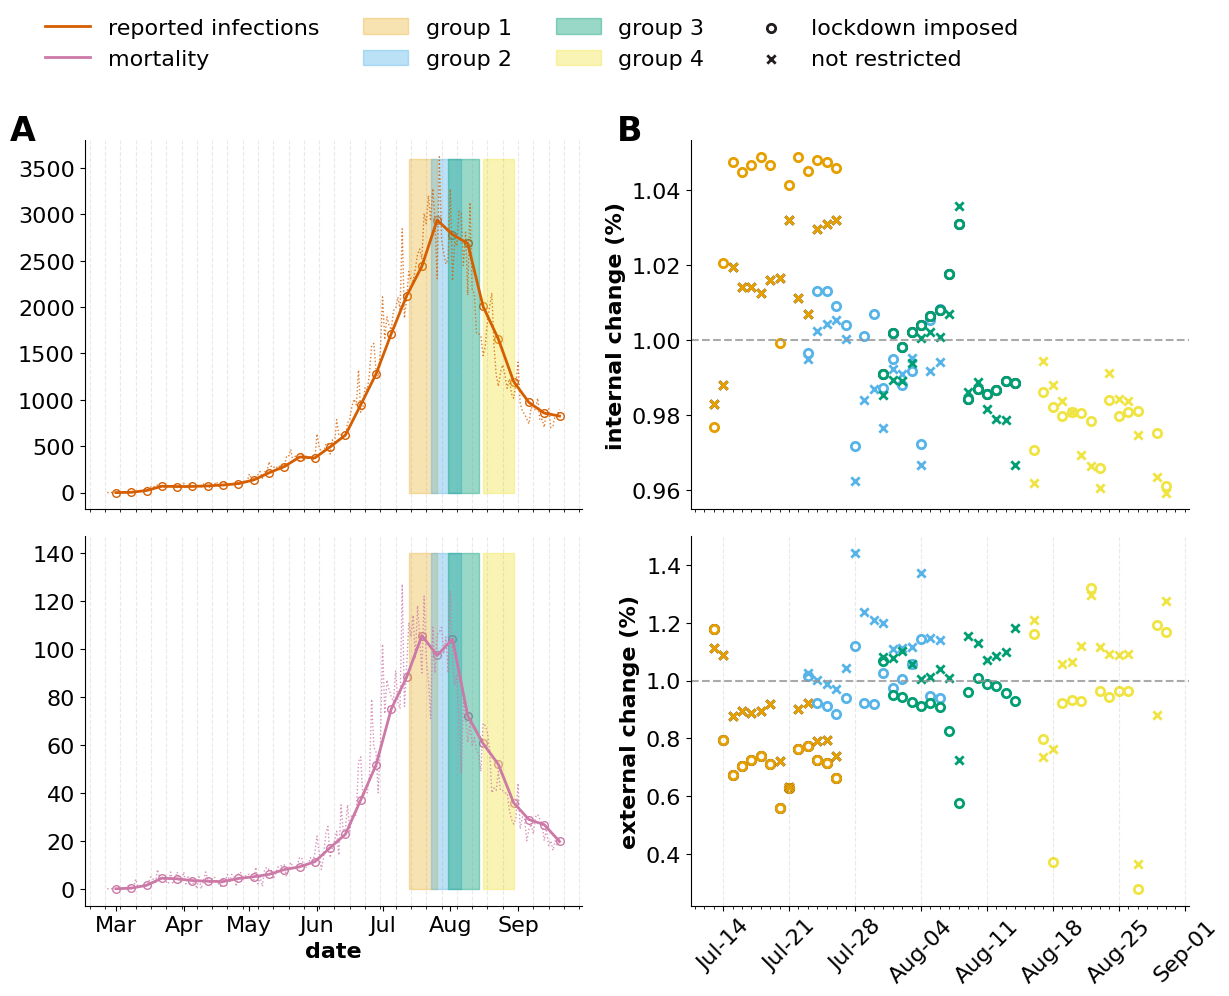

In [ ]:
layout = [["infections",  "internal"],
            ["deaths", "external"]]

fig, axes = plt.subplot_mosaic(layout,
                                figsize=(12.5, 9.2),
                                sharex=False, sharey=False)


axes["infections"].plot(bog_df["date"], bog_df["cases"], color=palette_guide[-2], ls=":", lw=1, alpha=0.8)
l_inf,  = axes["infections"].plot(bog_w_df["date"], bog_w_df["weekly_cases"], lw=2, ls="-", color=palette_guide[-2], label="reported infections")
axes["infections"].scatter(bog_w_df["date"], bog_w_df["weekly_cases"], ec=palette_guide[-2], fc="w", s=30)

lg1 = axes["infections"].fill_between([dates_lockdown01[0], dates_lockdown01[-1]], 0, 3600, color = palette_guide[0], alpha=0.3, label = "group 1")
lg2 = axes["infections"].fill_between([dates_lockdown02[0], dates_lockdown02[-1]], 0, 3600, color = palette_guide[1], alpha=0.4, label = "group 2")
lg3 = axes["infections"].fill_between([dates_lockdown03[0], dates_lockdown03[-1]], 0, 3600, color = palette_guide[2], alpha=0.4, label = "group 3")
lg4 = axes["infections"].fill_between([dates_lockdown04[0], dates_lockdown04[-1]], 0, 3600, color = palette_guide[3], alpha=0.4, label = "group 4")

axes["deaths"].plot(bog_df["date"], bog_df["deaths"], color=palette_guide[-1], ls=":", lw=1, alpha=0.8)
l_deaths, = axes["deaths"].plot(bog_w_df["date"], bog_w_df["weekly_deaths"], lw=2, ls="-", color=palette_guide[-1], label="mortality")
axes["deaths"].scatter(bog_w_df["date"], bog_w_df["weekly_deaths"], ec=palette_guide[-1], fc="w", s=30)
axes["deaths"].fill_between([dates_lockdown01[0], dates_lockdown01[-1]], 0, 140, color = palette_guide[0], alpha=0.3)
axes["deaths"].fill_between([dates_lockdown02[0], dates_lockdown02[-1]], 0, 140, color = palette_guide[1], alpha=0.4)
axes["deaths"].fill_between([dates_lockdown03[0], dates_lockdown03[-1]], 0, 140, color = palette_guide[2], alpha=0.4)
axes["deaths"].fill_between([dates_lockdown04[0], dates_lockdown04[-1]], 0, 140, color = palette_guide[3], alpha=0.4)

###########


for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):
    localities_left = list(set(cases_bog_df.locality.unique()) - set(lockdown))
    if i_lck > 0:
        prev_dates = dates_lockdown[i_lck-1]
    else:
        prev_dates =  dates_lockdown[i_lck] - pd.Timedelta(days=14) #dates_lockdown[i_lck-1]

    ext_mov_gr01_df     = ext_mov_df[ext_mov_df["start_poly_id"].isin(lockdown)]
    ext_mov_not_gr01_df = ext_mov_df[ext_mov_df["start_poly_id"].isin(localities_left)]

    # - #
    ext_g01_df                = ext_mov_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_g01_df                = ext_g01_df[ext_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    ext_g01_df["day_of_week"] = ext_g01_df["date_time"].apply(lambda x: x.weekday())
    # - #

    ext_prev_g01_df                = ext_mov_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_prev_g01_df                = ext_prev_g01_df[ext_prev_g01_df["date_time"].isin(prev_dates)]
    ext_prev_g01_df["day_of_week"] = ext_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    ext_prev_g01_df                = ext_prev_g01_df.groupby(['start_poly_id', 'end_poly_id', 'day_of_week']).mean().reset_index()

    ext_g01_df                           = pd.merge(ext_g01_df, ext_prev_g01_df[["start_poly_id", "end_poly_id", "day_of_week", "movement"]], on=["start_poly_id", "end_poly_id", "day_of_week"], how="outer")
    ext_g01_df["change_in_ext_movement"] = ext_g01_df["movement_x"] / ext_g01_df["movement_y"]

    ext_g01_mean_df = ext_g01_df[["date_time", "change_in_ext_movement"]].groupby(['date_time']).mean().reset_index()

    ext_g01_df['pair']     = ext_g01_df.apply(lambda x: x.start_poly_id+"-"+x.end_poly_id, axis=1)
    mean_ext_df            = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.mean()
    quantiles_df           = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").quantile([0.05, 0.95], axis=1).T
    quantiles_df["mean"]   = mean_ext_df
    quantiles_df["median"] = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.median()
    quantiles_df = quantiles_df.dropna()

    label = None
    if i_lck == 0:
        label = "lockdown imposed"
        axes["external"].scatter(quantiles_df.index.values, quantiles_df["median"], label=label,
                                                    ec=palette_grays[0], fc="w", lw=2, alpha=1)
    axes["external"].scatter(quantiles_df.index.values, quantiles_df["median"],
                                                    ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)

    # - # - # HERE FOR THE LOCALITIES NOT QUARANTINED # - # - #

    ext_g01_df                = ext_mov_not_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_g01_df                = ext_g01_df[ext_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    ext_g01_df["day_of_week"] = ext_g01_df["date_time"].apply(lambda x: x.weekday())

    ext_prev_g01_df                = ext_mov_not_gr01_df[["date_time", "movement", "start_poly_id", "end_poly_id"]].groupby(['date_time', "start_poly_id", "end_poly_id"]).mean().reset_index()
    ext_prev_g01_df                = ext_prev_g01_df[ext_prev_g01_df["date_time"].isin(prev_dates)]
    ext_prev_g01_df["day_of_week"] = ext_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    ext_prev_g01_df                = ext_prev_g01_df.groupby(['start_poly_id', 'end_poly_id', 'day_of_week']).mean().reset_index()

    ext_g01_df                           = pd.merge(ext_g01_df, ext_prev_g01_df[["start_poly_id", "end_poly_id", "day_of_week", "movement"]], on=["start_poly_id", "end_poly_id", "day_of_week"], how="outer")
    ext_g01_df["change_in_ext_movement"] = ext_g01_df["movement_x"] / ext_g01_df["movement_y"]

    ext_g01_mean_df = ext_g01_df[["date_time", "change_in_ext_movement"]].groupby(['date_time']).mean().reset_index()

    ext_g01_df['pair']     = ext_g01_df.apply(lambda x: x.start_poly_id+"-"+x.end_poly_id, axis=1)
    mean_ext_df            = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.mean()
    quantiles_df           = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").quantile([0.05, 0.95], axis=1).T
    quantiles_df["mean"]   = mean_ext_df
    quantiles_df["median"] = ext_g01_df.pivot(index="date_time", columns="pair", values="change_in_ext_movement").T.median()
    quantiles_df = quantiles_df.dropna()

    label = None
    if i_lck == 0:
        label = "not restricted"
        axes["external"].scatter(quantiles_df.index.values, quantiles_df["median"], c=palette_grays[0], lw=2, marker="x", label=label)
    axes["external"].scatter(quantiles_df.index.values, quantiles_df["median"], c=palette_guide[i_lck], lw=2, marker="x")
axes["external"].axhline(y=1, color=palette_grays[1], ls="--", lw=1.5, alpha=0.8)
axes["external"].set_ylabel("external change (%)", weight="bold")

############## - ############## - ##############

for i_lck, lockdown in enumerate([locs_01, locs_02, locs_03, locs_04]):
    localities_left     = list(set(cases_bog_df.locality.unique()) - set(lockdown))
    int_mov_gr01_df     = int_mov_df[int_mov_df["start_poly_id"].isin(lockdown)]
    int_mov_not_gr01_df = int_mov_df[int_mov_df["start_poly_id"].isin(localities_left)]
    bog_g01_df          = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df          = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]

    if i_lck > 0:
        pre_dates_lock = dates_lockdown[i_lck-1]
    else:
        pre_dates_lock = dates_lockdown[i_lck] - pd.Timedelta(days=14)

    bog_prev_g01_df = int_mov_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_prev_g01_df = bog_prev_g01_df[bog_prev_g01_df["date_time"].isin(pre_dates_lock)]
    ##
    bog_prev_g01_df["day_of_week"] = bog_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_prev_g01_df                = bog_prev_g01_df.groupby(['day_of_week']).mean().reset_index()
    bog_g01_df["day_of_week"]      = bog_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_g01_df                     = pd.merge(bog_g01_df, bog_prev_g01_df[["day_of_week", "movement"]],
                                                                            on="day_of_week", how="outer")
    bog_g01_df["change_in_internal_movement"] = bog_g01_df["movement_x"] / bog_g01_df["movement_y"]
    bog_g01_df["group"] = i_lck+1

    label    = None
    if i_lck == 2:
        label = "lockdown imposed"
        line_lab_ext = axes["internal"].scatter(bog_g01_df["date_time"],
                                bog_g01_df["change_in_internal_movement"],
                                ec=palette_grays[0], fc="w", lw=2, label=label)
    if i_lck == 3:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.6, it=10)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        axes["internal"].scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)
    elif i_lck==0:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.55, it=100)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        axes["internal"].scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)
    else:
        axes["internal"].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"], ec=palette_guide[i_lck], fc="w", lw=2, alpha=1)

    ####  not locked down

    bog_prev_g01_df = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_prev_g01_df = bog_prev_g01_df[bog_prev_g01_df["date_time"].isin(pre_dates_lock)]
    ##
    bog_prev_g01_df["day_of_week"] = bog_prev_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_prev_g01_df                = bog_prev_g01_df.groupby(['day_of_week']).mean().reset_index()

    bog_g01_df                     = int_mov_not_gr01_df[["date_time", "movement"]].groupby(['date_time']).mean().reset_index()
    bog_g01_df                     = bog_g01_df[bog_g01_df["date_time"].isin(dates_lockdown[i_lck])]
    bog_g01_df["day_of_week"]      = bog_g01_df["date_time"].apply(lambda x: x.weekday())
    bog_g01_df                     = pd.merge(bog_g01_df, bog_prev_g01_df[["day_of_week", "movement"]],
                                                                            on="day_of_week", how="outer")
    bog_g01_df["change_in_internal_movement"] = bog_g01_df["movement_x"] / bog_g01_df["movement_y"]
    bog_g01_df["group"] = i_lck+1

    label = None
    if i_lck == 0:
        label = "not restricted"
        line_lab_int = axes["internal"].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
                                                    c=palette_grays[0], lw=2, marker="x", label=label)
    if i_lck == 3:
        filtered = lowess(bog_g01_df["change_in_internal_movement"], range(len(bog_g01_df["date_time"])),
                                                                            is_sorted=True, frac=0.6, it=10)
        bog_g01_df["change_in_internal_movement_sm"] = bog_g01_df["change_in_internal_movement"]
        axes["internal"].scatter(x=bog_g01_df["date_time"], y=np.squeeze(filtered[:, 1]), marker="x", fc=palette_guide[i_lck], lw=2, alpha=1)
    else:
        axes["internal"].scatter(bog_g01_df["date_time"], bog_g01_df["change_in_internal_movement"],
                                            ec=palette_guide[i_lck], marker="x", fc=palette_guide[i_lck], lw=2, alpha=1)
    #intern_mov_df = intern_mov_df + [bog_g01_df]

axes["internal"].axhline(y=1, color=palette_grays[1], ls="--", lw=1.5, alpha=0.8)
axes["internal"].set_ylabel("internal change (%)", weight="bold")
#axes["internal"].legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), frameon=False, ncol=2)

for axi in [axes["internal"], axes["external"]]:
    axi.grid(axis='x', which="major", linestyle='--', alpha=0.2, color=palette_grays[1])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axi.tick_params(which='both', axis='x', labelrotation=45)
    axi.xaxis.set_major_locator(mdates.WeekdayLocator())
    axi.xaxis.set_minor_locator(mdates.DayLocator())
    axi.spines['right'].set_visible( False )
    axi.spines['top'].set_visible( False )

for axi in [axes["infections"], axes["deaths"]]:
    axi.grid(axis='x', which="minor", linestyle='--', alpha=0.2, color=palette_grays[1])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axi.tick_params(which='both', axis='x', labelrotation=0)
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.legend(handles=[l_inf, l_deaths, lg1, lg2, lg3, lg4, line_lab_ext, line_lab_int], ncols=4,
                                    loc='upper left', bbox_to_anchor=(0.025, 1.1), frameon=False)
axes["deaths"].set_xlabel("date", weight='bold')

axes["infections"].set_xticks([])
axes["internal"].set_xticks([])

axes["infections"].text(x=-0.15, y=1.0, s="A", weight="bold", transform=axes["infections"].transAxes, fontsize=24)
axes["internal"].text(x=-0.15, y=1.0, s="B", weight="bold", transform=axes["internal"].transAxes, fontsize=24)

plt.tight_layout()

fig.savefig(os.path.join('figures',  'Fig1_mobility_changes.png'), dpi=300, bbox_inches='tight')

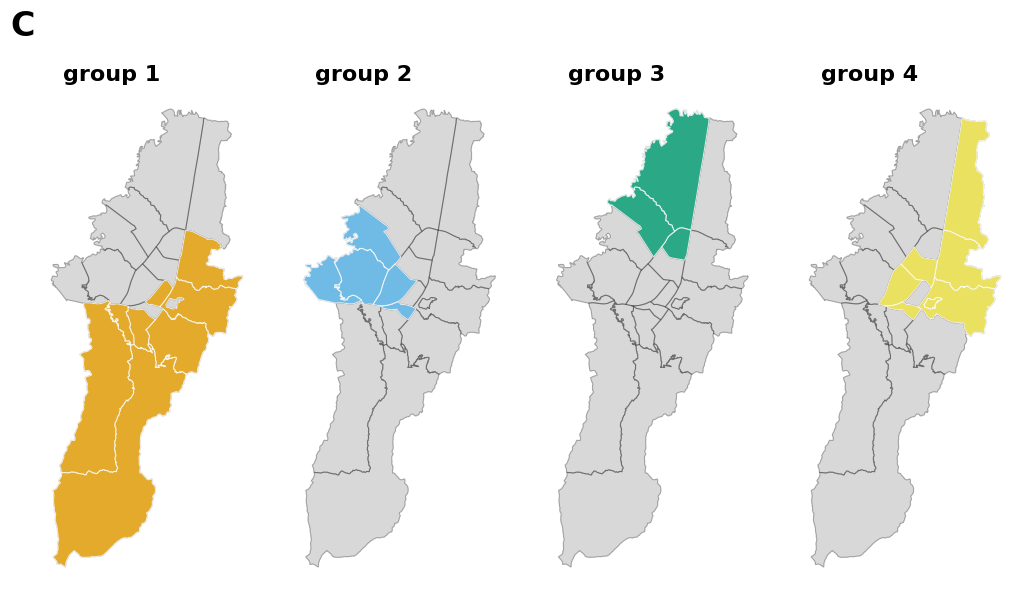

In [104]:
#########
fig, ax = plt.subplots(1, 4, figsize=(12.5, 9.2), sharex=True, sharey=True)

groups = ["group_1", "group_2", "group_3", "group_4"]
for i_axi, group in enumerate(groups):
    map_plot = "map"+str(i_axi+1)

    maps1 = polygons_bog.plot(ax=ax[i_axi], edgecolor='k', alpha=0.3, facecolor='Grey', linewidth=0.8)
    maps2 = polygons_bog[polygons_bog[group]==True].plot(ax=ax[i_axi], edgecolor="w",
                                    facecolor = palette_guide[i_axi], alpha=0.8, linewidth=0.8)

    ax[i_axi].text(x=0.1, y=1.01, weight="bold", s=f"group {i_axi+1}", transform=ax[i_axi].transAxes)
    ax[i_axi].set_axis_off()
    ax[i_axi].transAxes

ax[0].text(x=-0.15, y=1.1, s="C", weight="bold", transform=ax[0].transAxes, fontsize=24)
fig.savefig(os.path.join('figures',  'Fig1_maps.png'), dpi=300, bbox_inches='tight')
